# Time Series classification of Aerodynamics
The boundary layer on an airfoil can be in two states, Laminar or Turbulent. Visually this switch is quite easy to see, for the aerodynamics muggles, the turbulent boundary layer state with show up on the time series data from the microphone as very turbulent(or volatile if you are from the finance world). 
Other ways to solve this problem include
- Traditional signal processing tricks that can extract such a change over of course. 
- Bayesian switch point analysis with a flexible number of switch points would also work. 
- The auto-regressive type models<br>
But I wanted to try my hand at getting a time series model in torch working, so here we are. 

In [2]:
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up Model
One layer LSTM to multi layer fully conencted.
Sigmoid on the out layer as it is a classification problem. 
More layers can be enabled but 91% Validation error is possible with our the second lstm and extra fc layers. 

In [3]:
class Classifier(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(Classifier,self).__init__()
        
        self.lstm1 = nn.LSTMCell(input_size, hidden_size)
        #self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.layer1 = nn.Linear(hidden_size,hidden_size)
        self.ReLU1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size,hidden_size)
        self.ReLU2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size,hidden_size)
        self.ReLU3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size,output_size)
        self.Sigmoid = nn.Sigmoid()
    def forward(self,input):
        #print(input.shape)
        h_out = torch.zeros(input.size(0), 6).cuda()
        c_out = torch.zeros(input.size(0), 6).cuda()
        #h2_out = torch.zeros(input.size(0), 6).cuda()
        #c2_out = torch.zeros(input.size(0), 6).cuda()
        
        h_out, c_out = self.lstm1(input,(h_out, c_out))
        #h2_out, c2_out = self.lstm2(h_out,(h2_out, c2_out))
        #out = self.lstm2(out)
        out = self.layer1(h_out)
        out = self.ReLU1(out)
        #out = self.layer2(out)
        #out = self.ReLU2(out)
        #out = self.layer3(out)
        #out = self.ReLU3(out)
        out = self.layer4(out)
        out = self.Sigmoid(out)
        return out 

# Read in data
The features of the time series have been pre-processed to include the time series itself and the first 5 mel-spectrum coefficients. 
!!! Need to double check for data leakage in the mel-spectrum coefficients 

In [4]:
df = pd.read_pickle("Reduced.pkl")
Split = 0.8
SplitInd = int(Split * len(df))
LabelList = ['ts',*range(5)]
Input = torch.tensor(df[LabelList].values)
Output = torch.tensor(df['Labels'].values)

#load second file hacky way for now. Only two files needed for training set.  
df3 = pd.read_pickle("Reduced3.pkl")

Input3 = torch.tensor(df3[LabelList].values)
Output3 = torch.tensor(df3['Labels'].values)

#Valid trainSplit
InpTrain, InpValid = Input[:SplitInd], Input[SplitInd:]
OutTrain, OutValid = Output[:SplitInd], Output[SplitInd:]

#Valid trainSplit
InpTrain3, InpValid3 = Input3[:SplitInd], Input3[SplitInd:]
OutTrain3, OutValid3 = Output3[:SplitInd], Output3[SplitInd:]

#Concat two files. 
InputTrain = torch.cat((InpTrain,InpTrain3),0)
InputValid = torch.cat((InpValid,InpValid3),0)
OutputTrain = torch.cat((OutTrain,OutTrain3),0)
OutputValid = torch.cat((OutValid,OutValid3),0)

#Train scaler on training data only. No peeking now!! 
InpScaler = StandardScaler()
InpScaler.fit(InpTrain)

InpTrain = torch.tensor(InpScaler.transform(InpTrain))
InpValid = torch.tensor(InpScaler.transform(InpValid))

#Into DataLoaders
# Large Batch size seems to perform better. 
TrainDataSet = torch.utils.data.TensorDataset(InpTrain, OutTrain)
Train = torch.utils.data.DataLoader(TrainDataSet,batch_size = 200000,num_workers = 1)

ValidDataSet = torch.utils.data.TensorDataset(InpValid, OutValid)
Valid = torch.utils.data.DataLoader(TrainDataSet,batch_size = 200000,num_workers = 1)
LenTrain = len(InpTrain)
LenValid = len(InpValid)

# Initiate with Simple paralell architecture 

In [5]:
model = Classifier(6,6,1)
model.cuda()

Classifier(
  (lstm1): LSTMCell(6, 6)
  (layer1): Linear(in_features=6, out_features=6, bias=True)
  (ReLU1): ReLU()
  (layer2): Linear(in_features=6, out_features=6, bias=True)
  (ReLU2): ReLU()
  (layer3): Linear(in_features=6, out_features=6, bias=True)
  (ReLU3): ReLU()
  (layer4): Linear(in_features=6, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

# Simple SGD optimizer
Achieved 91% without momentum, Cosine Annealing appears effective from training. 
Have to implement a LR finder to better set. Works for now, probably go achieve much faster training

In [6]:
optimizer = torch.optim.SGD(model.parameters(),2,momentum = 0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,10,0.1)

epoch0
train loss: 1.383762719342485e-05
[0.1464963095196048]
epoch1
train loss: 1.3720161405217368e-05
[0.1]
epoch2
train loss: 1.3672794011654332e-05
valid loss: 1.3514819329429884e-05
accuracy: 91.16799831390381 %
saved


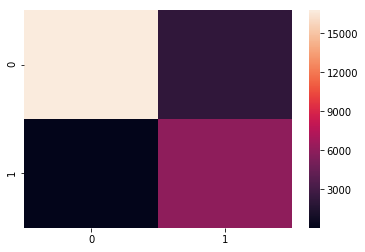

[0.1464963095196034]
epoch3
train loss: 1.3633743037644308e-05
[0.2814338553437996]
epoch4
train loss: 1.3568072972702794e-05
valid loss: 1.2956452337675728e-05
accuracy: 91.211998462677 %
saved


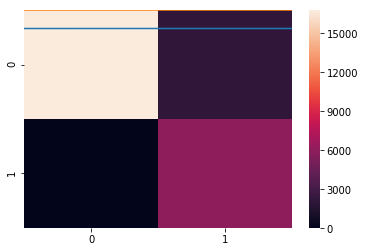

[0.4916040103221514]
epoch5
train loss: 1.4128973816696089e-05
[0.7564338553437993]
epoch6
train loss: 1.647203134780284e-05
valid loss: 1.6906378732528538e-05
accuracy: 88.49200010299683 %


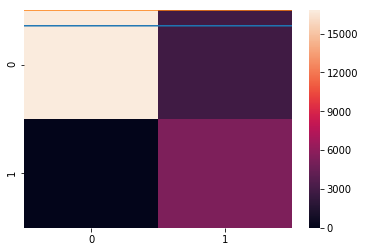

[1.050000000000001]
epoch7
train loss: 1.8528897271608002e-05
[1.3435661446561995]
epoch8
train loss: 1.699021231615916e-05
valid loss: 1.5316103599616326e-05
accuracy: 89.10399675369263 %


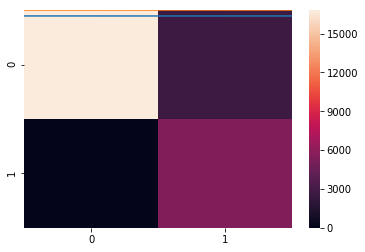

[1.6083959896778477]
epoch9
train loss: 2.4878952899598517e-05
[1.8185661446561996]
epoch10
train loss: 3.747010123333894e-05
valid loss: 2.06952536245808e-05
accuracy: 87.46399879455566 %


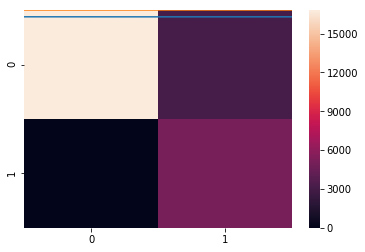

[1.953503690480395]
epoch11
train loss: 2.1177795133553445e-05
[2.0]
epoch12
train loss: 1.9840552340610884e-05
valid loss: 1.601801886863541e-05
accuracy: 88.10399770736694 %


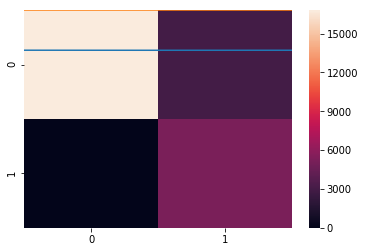

[1.9535036904803955]
epoch13
train loss: 1.8591446860227734e-05
[1.8185661446562005]
epoch14
train loss: 1.7324049622402526e-05
valid loss: 1.49705911098863e-05
accuracy: 88.79599571228027 %


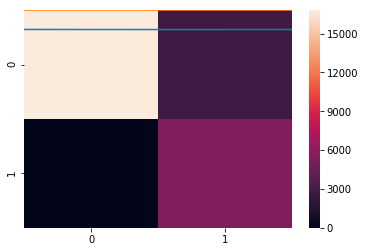

[1.6083959896778488]
epoch15
train loss: 1.6194793715840206e-05
[1.3435661446562008]
epoch16
train loss: 1.528584471088834e-05
valid loss: 1.41931550388108e-05
accuracy: 89.60399627685547 %


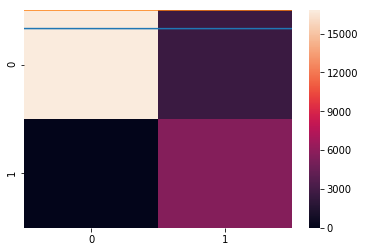

[1.0500000000000025]
epoch17
train loss: 1.4608219316869508e-05
[0.7564338553438006]
epoch18
train loss: 1.416347276972374e-05
valid loss: 1.37816850838135e-05
accuracy: 90.23199677467346 %


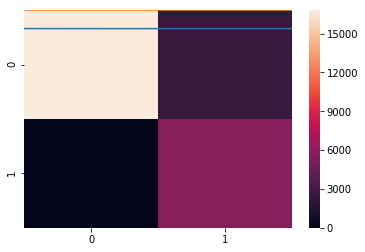

[0.4916040103221525]
epoch19
train loss: 1.3897750250180252e-05
[0.28143385534380044]
epoch20
train loss: 1.375636384182144e-05
valid loss: 1.365898788208142e-05
accuracy: 90.40799736976624 %


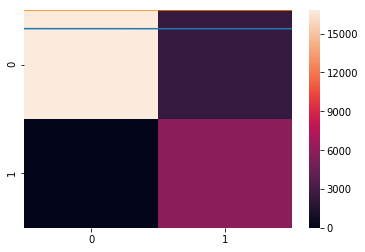

[0.14649630951960382]
epoch21
train loss: 1.3697177564608864e-05
[0.1]
epoch22
train loss: 1.3689344086742494e-05
valid loss: 1.3590737580670975e-05
accuracy: 90.52000045776367 %


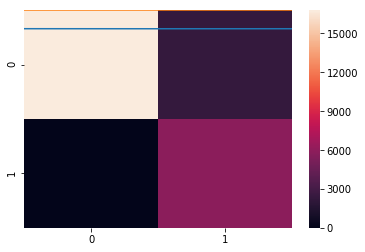

[0.14649630951960435]
epoch23
train loss: 1.370687095914036e-05
[0.2814338553437995]
epoch24
train loss: 1.3716461580770556e-05
valid loss: 1.33245594042819e-05
accuracy: 90.71999788284302 %


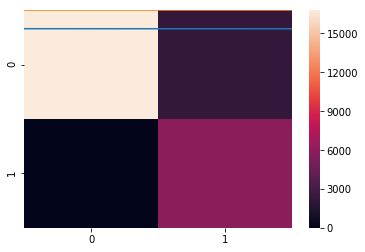

[0.4916040103221485]
epoch25
train loss: 1.3689473234990146e-05
[0.756433855343799]
epoch26
train loss: 1.3635974937642459e-05
valid loss: 1.2680311556323431e-05
accuracy: 91.06799960136414 %


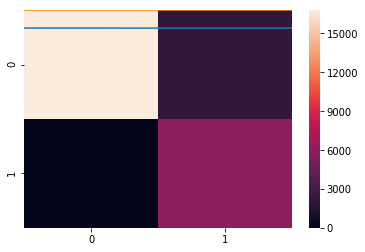

[1.0499999999999974]
epoch27
train loss: 1.3640917131851893e-05
[1.3435661446561993]
epoch28
train loss: 1.4091084267420229e-05
valid loss: 1.286814222112298e-05
accuracy: 90.49999713897705 %


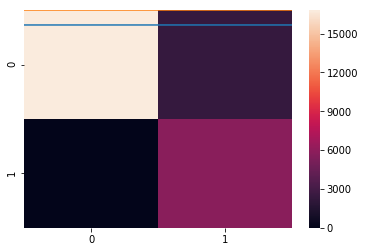

[1.6083959896778501]
epoch29
train loss: 1.584116034791805e-05
[1.8185661446561996]
epoch30
train loss: 1.6684185538906604e-05
valid loss: 1.2744842024403624e-05
accuracy: 90.9879982471466 %


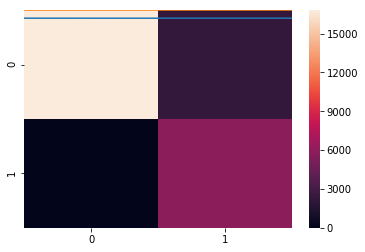

[1.9535036904803962]
epoch31
train loss: 1.3868858331989031e-05
[2.0]
epoch32
train loss: 1.3766599295195192e-05
valid loss: 1.4880050912324805e-05
accuracy: 89.35999870300293 %


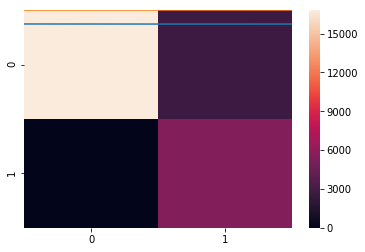

[1.9535036904803968]
epoch33
train loss: 1.4401934095076285e-05
[1.8185661446562027]
epoch34
train loss: 1.2571563274832442e-05
valid loss: 1.1581651051528752e-05
accuracy: 92.16399788856506 %
saved


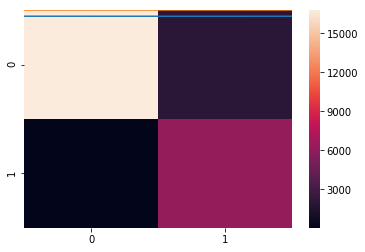

[1.6083959896778488]
epoch35
train loss: 1.1952770364587195e-05
[1.343566144656201]
epoch36
train loss: 1.1673928383970633e-05
valid loss: 1.1954261026403401e-05
accuracy: 91.27599596977234 %


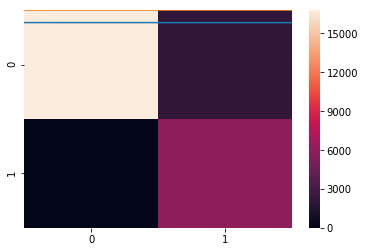

[1.0499999999999992]
epoch37
train loss: 1.1416358574933838e-05
[0.7564338553438009]
epoch38
train loss: 1.1033678674721159e-05
valid loss: 1.0855104846996255e-05
accuracy: 92.85999536514282 %
saved


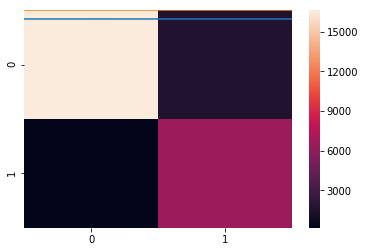

[0.49160401032215273]
epoch39
train loss: 1.0902308531512972e-05
[0.28143385534380255]
epoch40
train loss: 1.0834816748683807e-05
valid loss: 1.078958848665934e-05
accuracy: 92.84799695014954 %


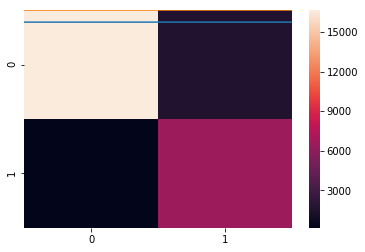

[0.14649630951960393]
epoch41
train loss: 1.0806877980940044e-05
[0.1]
epoch42
train loss: 1.0803563782246783e-05
valid loss: 1.0757599739008583e-05
accuracy: 92.85199642181396 %


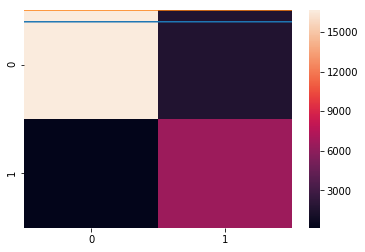

[0.1464963095196033]
epoch43
train loss: 1.0817497241077945e-05
[0.2814338553437993]
epoch44
train loss: 1.0897740139625967e-05
valid loss: 1.0874198778765276e-05
accuracy: 92.36799478530884 %


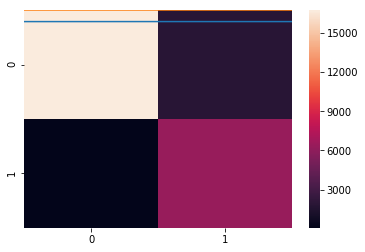

[0.4916040103221483]
epoch45
train loss: 1.215255724673625e-05
[0.756433855343802]
epoch46
train loss: 1.2016810615023132e-05
valid loss: 1.0908815966104157e-05
accuracy: 92.83599853515625 %


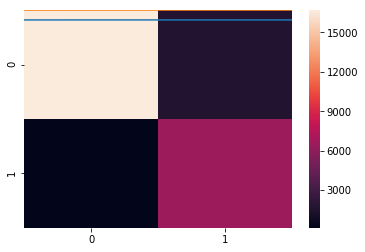

[1.0500000000000007]
epoch47
train loss: 1.1595822797971778e-05
[1.343566144656199]
epoch48
train loss: 1.454655830457341e-05
valid loss: 1.754812547005713e-05
accuracy: 88.36399912834167 %


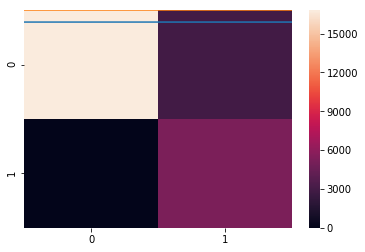

[1.6083959896778472]
epoch49
train loss: 1.64395896717906e-05
[1.8185661446561976]


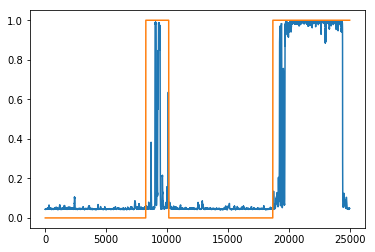

In [18]:
# Training Loop 

highest = 0
for k in range(10):
    running_loss= 0 
    corrects = 0
    #Train
    for inp, target in Train:
        optimizer.zero_grad()
        inp = inp.cuda()
        output = model.forward(inp.float())
        loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) 
        #loss = CrossEntropy(output, target.float().reshape(output.shape).cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss/len(target)  
    if k % 1==0: 
        print("epoch{}".format(k))
        print("train loss: {}".format(running_loss))    
    running_loss= 0 
    # Added the option of just running the Training step for the first few epochs.
    if k > 1:
        # Validate. 
        for inp, target in Valid:
            inp = inp.cuda()
            output = model.forward(inp.float())
            loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) 
            #Track Epoch Loss
            running_loss += loss/len(target)
            a = (output>0.5) 
            b= target.reshape(output.shape).cuda()>0.5 
        
        #Print out. 
        if k % 2 ==0: 
            print("valid loss: {}".format(running_loss))
            print("accuracy: {} %".format((a==b).float().mean().item()*100))
            if ((a==b).float().mean().item()*100)> highest:
                highest = ((a==b).float().mean().item()*100)
                #Save out model that achieves best accuracy. 
                torch.save(model.state_dict(), './ModelSave.pt')
                print("saved")
            sns.heatmap(confusion_matrix(a.cpu().numpy(),b.cpu().numpy()))
            plt.show()
            
    print("Learning Rate:{}".format(scheduler.get_lr()))
    scheduler.step() 

# Evaluate Model
 Load up the best performing model. Run the model and Plot the results. 

In [36]:
model2 = Classifier(6,6,1)
model2.load_state_dict(torch.load('./ModelSave.pt'))
model2.cuda()

df = pd.read_pickle("Reduced.pkl")
df3 = pd.read_pickle("Reduced3.pkl")
df.append(df3)
#Load into Torch Dataset. 
Input = torch.tensor(InpScaler.transform(df[LabelList].values))
Output = torch.tensor(df['Labels'].values)

MainDataSet = torch.utils.data.TensorDataset(Input, Output)
Main = torch.utils.data.DataLoader(MainDataSet,batch_size = 200000,num_workers = 1)
full_results = torch.Tensor()
#Run Model over the batches. 
for inp, Label in Main:
    inp = inp.cuda()
    output = model2.forward(inp.float())
    
    third_tensor = torch.cat((inp.cpu().float(),output.cpu().float()), 1)
    third_tensor = torch.cat((third_tensor,Label.reshape(output.shape).float()), 1)
    full_results = torch.cat((full_results,third_tensor),0)

<IPython.core.display.Javascript object>


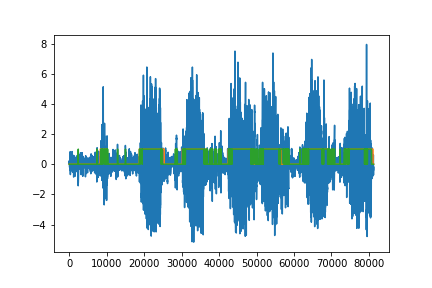

In [42]:
%matplotlib notebook
plt.plot(third_tensor[:,0])
plt.plot(third_tensor[:,-1])         
plt.plot(third_tensor[:,-2]>0.5) 


<IPython.core.display.Javascript object>


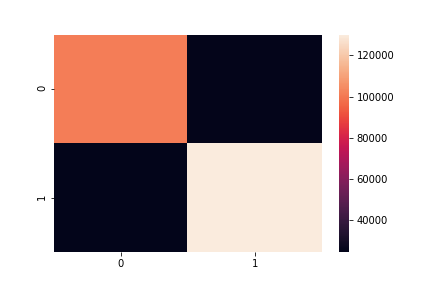

In [38]:
#Confusion Plot. 
plt.figure()
full_results.detach().numpy()
full_results[:,-2] = full_results[:,-2]>0.5
sns.heatmap(confusion_matrix(full_results[:,-2].detach().numpy(),full_results[:,-1].detach().numpy()))
plt.show()

<IPython.core.display.Javascript object>


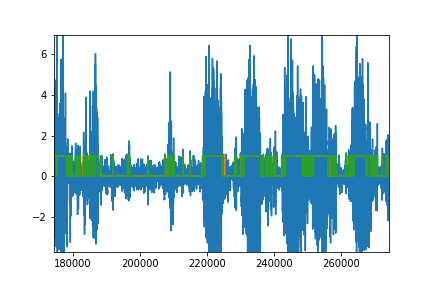

In [40]:
#Time Series
plt.figure()
plt.plot(full_results[:,0])
plt.plot(full_results[:,-1])
plt.plot(full_results[:,-2])
plt.show()